In [1]:
# Importy
import torch
import numpy as np
import pandas as pd
import torch.utils.data as data
import torch.nn as nn
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Wczytanie danych
df = pd.read_csv("../data/final_data.csv", delimiter=';')
df = df[df['price'].notna()]
df = df[df['price'] > 0]
df = df[df['price'] < 10000]
df.drop(columns=['id'], inplace=True)

In [3]:
# Podział i log-transformacja ceny
train_df = df.sample(frac=0.8, random_state=205)
test_df = df.drop(train_df.index)

train_df['price'] = np.log1p(train_df['price'])
test_df['price'] = np.log1p(test_df['price'])

X_train = train_df.iloc[:, :-1].values
y_train = train_df.iloc[:, -1].values

X_test = test_df.iloc[:, :-1].values
y_test = test_df.iloc[:, -1].values

In [4]:
# Normalizacja cech
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [5]:
# Tensory i DataLoadery
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = data.TensorDataset(X_test_tensor, y_test_tensor)

train_loader = data.DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True)
test_loader = data.DataLoader(test_dataset, batch_size=64, shuffle=False, pin_memory=True)

In [6]:
# Definicja modelu
class PriceRegressor(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x).squeeze()

In [7]:
# Inicjalizacja
model = PriceRegressor(X_train_tensor.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [8]:
# Trenowanie
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

Epoch 1/100, Loss: 21.8028
Epoch 2/100, Loss: 16.1798
Epoch 3/100, Loss: 8.4463
Epoch 4/100, Loss: 2.8871
Epoch 5/100, Loss: 1.4594
Epoch 6/100, Loss: 1.1397
Epoch 7/100, Loss: 0.9614
Epoch 8/100, Loss: 0.8431
Epoch 9/100, Loss: 0.7617
Epoch 10/100, Loss: 0.7024
Epoch 11/100, Loss: 0.6564
Epoch 12/100, Loss: 0.6205
Epoch 13/100, Loss: 0.5919
Epoch 14/100, Loss: 0.5672
Epoch 15/100, Loss: 0.5470
Epoch 16/100, Loss: 0.5269
Epoch 17/100, Loss: 0.5125
Epoch 18/100, Loss: 0.4980
Epoch 19/100, Loss: 0.4848
Epoch 20/100, Loss: 0.4725
Epoch 21/100, Loss: 0.4619
Epoch 22/100, Loss: 0.4529
Epoch 23/100, Loss: 0.4437
Epoch 24/100, Loss: 0.4356
Epoch 25/100, Loss: 0.4296
Epoch 26/100, Loss: 0.4210
Epoch 27/100, Loss: 0.4140
Epoch 28/100, Loss: 0.4084
Epoch 29/100, Loss: 0.4024
Epoch 30/100, Loss: 0.3967
Epoch 31/100, Loss: 0.3915
Epoch 32/100, Loss: 0.3862
Epoch 33/100, Loss: 0.3817
Epoch 34/100, Loss: 0.3761
Epoch 35/100, Loss: 0.3726
Epoch 36/100, Loss: 0.3685
Epoch 37/100, Loss: 0.3635
Epoch 38

In [9]:
# Ewaluacja
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor.to(device))
    y_pred_log = y_pred_tensor.cpu().numpy()
    y_pred_log = np.clip(y_pred_log, 0, 10)  # zabezpieczenie
    y_true_log = y_test_tensor.numpy()

# Cofnięcie log1p
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_true_log)

# Metryki
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.4f}")

MAE:  136.21
RMSE: 546.05
R²:   0.2778


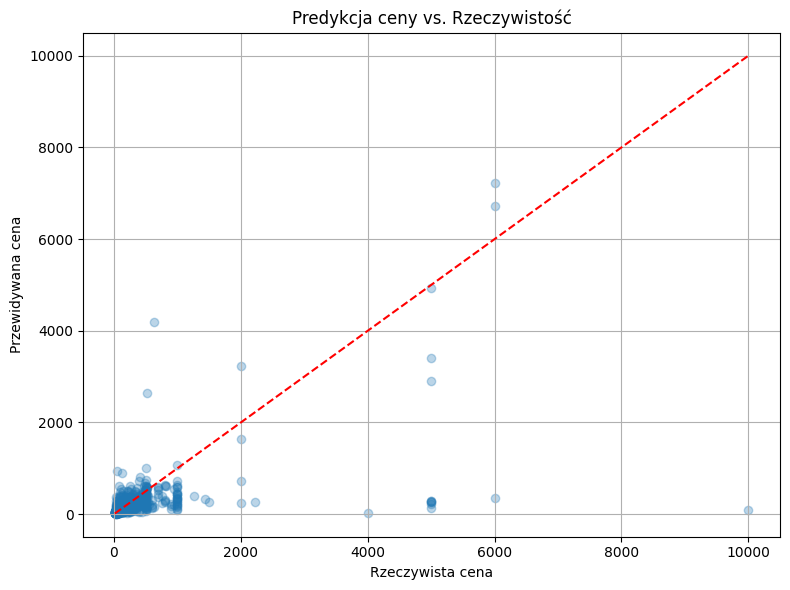

In [10]:
# Wykres
plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred, alpha=0.3)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel("Rzeczywista cena")
plt.ylabel("Przewidywana cena")
plt.title("Predykcja ceny vs. Rzeczywistość")
plt.grid(True)
plt.tight_layout()
plt.show()